# VGG16 모델 구현하기

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## 데이터 준비
- 원본 출처: https://www.kaggle.com/c/dogs-vs-cats/data
- 실습 이미지는 원본 데이터보다 크기가 작음
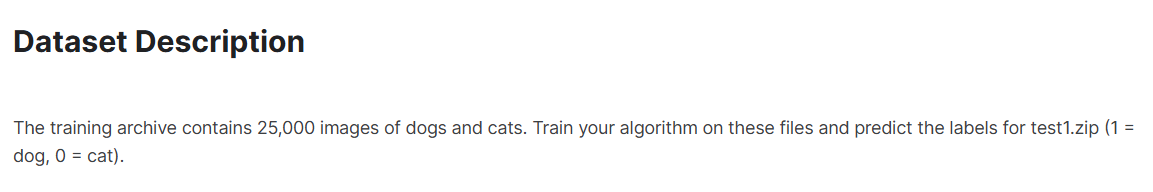

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 1s 0us/step


train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


train 데이터와 validation 데이터의 개수를 알아봅시다.

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


필요한 파라미터를 설정해 줍시다. 파라미터를 수정하면 성능을 높일 수 있으니 다양한 실험을 해보세요.

## 매개변수 초기화

In [6]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

이미지를 확인하기 위해 데이터를 시각화하는 함수를 만들어 봅시다. 간단한 함수이기 때문에 자세한 코드 설명은 생략하겠습니다. 궁금하다면 구글링을 통해 각 코드가 어떤 역할을 하는지 찾아보세요.

## 시각화 준비

In [36]:
from tensorflow.keras.utils import plot_model # 모델 시각화

%matplotlib inline

# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

train 데이터가 2천장 밖에 되지 않기 때문에 Data Augmentation(데이터 증강)을 통해 데이터의 수를 늘립니다.

Data Augmentation은 Rescale, Rotation, Random Crop, Zoom, Flip 등 다양한 기법을 사용하여 데이터의 양을 증가시키는 것입니다. range의 숫자를 변화시키거나 Flip에서 True/False를 적절하게 사용하여 다양한 실험을 해보세요.

## 이미지 제너레이터 설계

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

.flow_from_directory를 사용하여 파이프라인을 만들어 directory와 작업 환경을 연결시켜 줍니다. 우리는 개와 고양이를 분류하는 task를 수행하기 때문에class_mode는 'binary'입니다. Classification task에 따라 class_mode를 변경하시면 됩니다.

In [9]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Data Augmentation이 제대로 되었는지 확인해 봅시다.

In [10]:
train_data_gen

In [11]:
print(train_data_gen[0].shape)

''' 튜플이네 '''

AttributeError: 'tuple' object has no attribute 'shape'

In [12]:
print(train_data_gen[0])

''' 튜플 안에 랭크 4 텐서네 '''

(array([[[[6.00793004e-01, 6.08636141e-01, 5.97299993e-01],
         [6.00437820e-01, 6.08280957e-01, 5.96912563e-01],
         [6.00082636e-01, 6.07925773e-01, 5.96525013e-01],
         ...,
         [5.49019635e-01, 5.13521492e-01, 4.86121505e-01],
         [5.49019635e-01, 5.13586044e-01, 4.86169934e-01],
         [5.49019635e-01, 5.13650656e-01, 4.86218393e-01]],

        [[6.42571390e-01, 6.50414526e-01, 6.38649821e-01],
         [6.42797410e-01, 6.50640547e-01, 6.38875842e-01],
         [6.43023491e-01, 6.50866628e-01, 6.39101923e-01],
         ...,
         [5.49019635e-01, 5.20693958e-01, 4.96727169e-01],
         [5.49019635e-01, 5.20726264e-01, 4.96775597e-01],
         [5.49019635e-01, 5.20758510e-01, 4.96824056e-01]],

        [[6.74457073e-01, 6.82300210e-01, 6.64666295e-01],
         [6.74586177e-01, 6.82429314e-01, 6.64763212e-01],
         [6.74715400e-01, 6.82558537e-01, 6.64860070e-01],
         ...,
         [5.45921803e-01, 5.18470824e-01, 4.94941384e-01],
         

' 튜플 안에 랭크 4 텐서네 '

In [13]:
print(train_data_gen[0][0])

''' [3차원 이미지, 3차원 이미지, 3차원 이미지 ...] 과 같이 하나의 선 위에 큐빅이 나열되어 있겠네 '''

[[[[0.5420717  0.5139046  0.47612113]
   [0.55992216 0.51747465 0.50825197]
   [0.43846884 0.38174096 0.40447667]
   ...
   [0.6666667  0.67058825 0.75294125]
   [0.6666667  0.67058825 0.75294125]
   [0.6666667  0.67058825 0.75294125]]

  [[0.54205984 0.5139022  0.47609988]
   [0.55991036 0.5174723  0.50823075]
   [0.4385539  0.3818355  0.40454996]
   ...
   [0.6666667  0.67058825 0.75294125]
   [0.6666667  0.67058825 0.75294125]
   [0.6666667  0.67058825 0.75294125]]

  [[0.54204804 0.5138998  0.47607863]
   [0.5598985  0.5174699  0.50820947]
   [0.43863896 0.38193    0.4046232 ]
   ...
   [0.6666667  0.67058825 0.75294125]
   [0.6666667  0.67058825 0.75294125]
   [0.6666667  0.67058825 0.75294125]]

  ...

  [[0.31159353 0.32853624 0.19170015]
   [0.39649922 0.40273166 0.268628  ]
   [0.36641157 0.37593275 0.25099882]
   ...
   [0.2901961  0.40784317 0.20392159]
   [0.2901961  0.40784317 0.20392159]
   [0.2901961  0.40784317 0.20392159]]

  [[0.31164786 0.3285977  0.19176395]
   [0.3

' [3차원 이미지, 3차원 이미지, 3차원 이미지 ...] 과 같이 하나의 선 위에 큐빅이 나열되어 있겠네 '

In [14]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

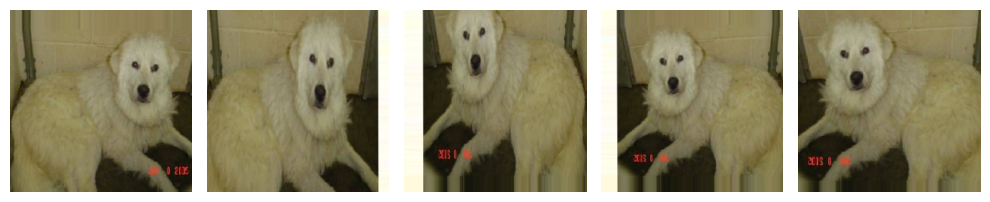

In [15]:
augmented_images = [train_data_gen[0][0][1] for i in range(5)]
plotImages(augmented_images)

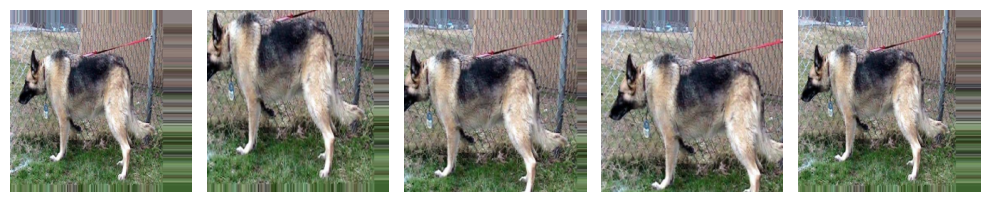

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

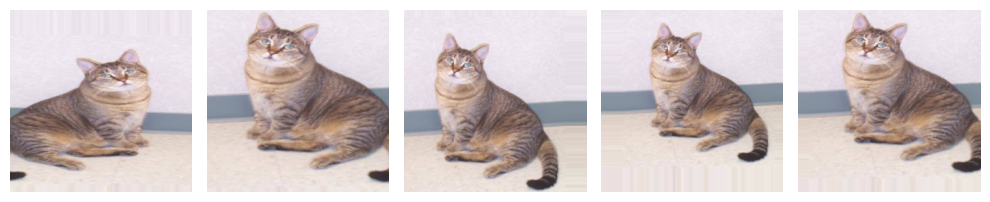

In [17]:
augmented_images = [train_data_gen[0][0][2] for i in range(5)]
plotImages(augmented_images)

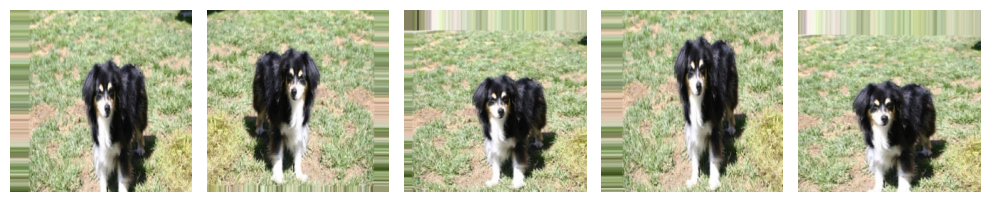

In [18]:
augmented_images = [train_data_gen[0][0][3] for i in range(5)]
plotImages(augmented_images)

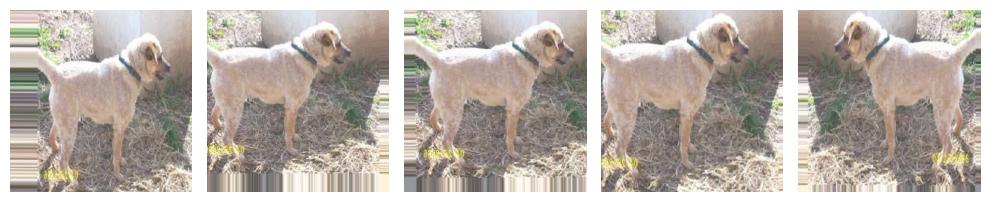

In [19]:
augmented_images = [train_data_gen[0][0][4] for i in range(5)]
plotImages(augmented_images)

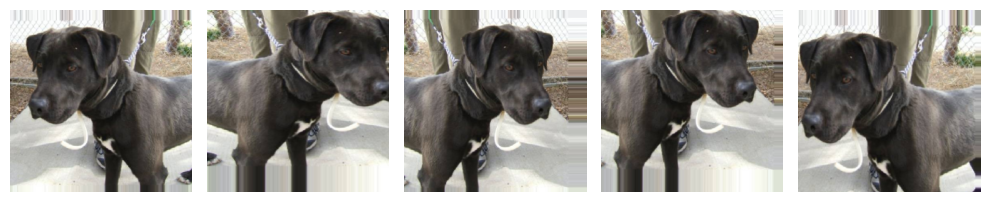

In [20]:
augmented_images = [train_data_gen[1][0][4] for i in range(5)]
plotImages(augmented_images)

Validation 데이터에도 train 데이터와 같은 동일한 작업을 해 줍니다. 그러나 Validation 데이터는 classification이 잘 되는지 평가하는 용도로 사용되기 때문에 데이터의 스케일만 변경해 줍니다.

In [21]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [22]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


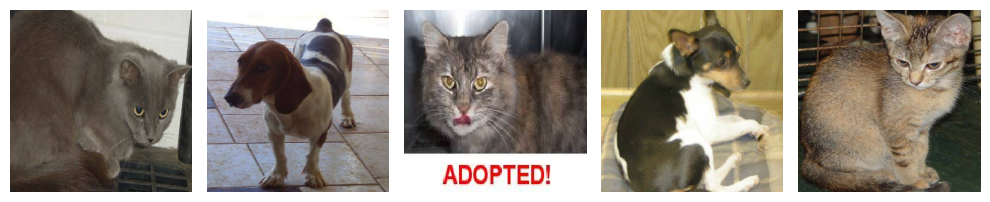

In [23]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [24]:
_[:5] # 정답 데이터

array([0., 1., 0., 1., 0.], dtype=float32)

## VGG16 모델 구현하기
이제 VGG16 모델을 구현해 볼 시간입니다. 바로 혼자서 모델을 구현하라고 하면 어렵겠죠? 그래서 참고할만한 모델 구현 코드를 아래에 적어 보았습니다. 실제 VGG16 모델과는 살짝 구조가 다르기 때문에 이미지를 보면서 어느 부분이 다른치 찾아 보는 것도 좋을 것 같습니다.

### 층 구성

In [25]:
input_layer=tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))


conv1=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
conv2=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(conv1)
conv2=tf.keras.layers.BatchNormalization()(conv2)
max1=tf.keras.layers.MaxPool2D((2, 2))(conv2)


conv3=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(max1)
conv4=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(conv3)
conv4=tf.keras.layers.BatchNormalization()(conv4)
max2=tf.keras.layers.MaxPool2D((2, 2))(conv4)


conv5=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(max2)
conv6=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv5)
conv7=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv6)
conv7=tf.keras.layers.BatchNormalization()(conv7)
max3=tf.keras.layers.MaxPool2D((2, 2))(conv7)


conv8=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max3)
conv9=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv8)
conv10=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv9)
conv10=tf.keras.layers.BatchNormalization()(conv10)
max4=tf.keras.layers.MaxPool2D((2, 2))(conv10)


conv11=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max4)
conv12=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv11)
conv13=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv12)
conv13=tf.keras.layers.BatchNormalization()(conv13)
max5=tf.keras.layers.MaxPool2D((2, 2))(conv13)


features=tf.keras.layers.Flatten()(max5)
f4096=tf.keras.layers.Dense(1024, activation='relu')(features)
f4096=tf.keras.layers.Dense(1024, activation='relu')(f4096)
f1000=tf.keras.layers.Dense(512, activation='relu')(f4096)
out_layer=tf.keras.layers.Dense(1, activation='softmax')(f1000)


model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856 

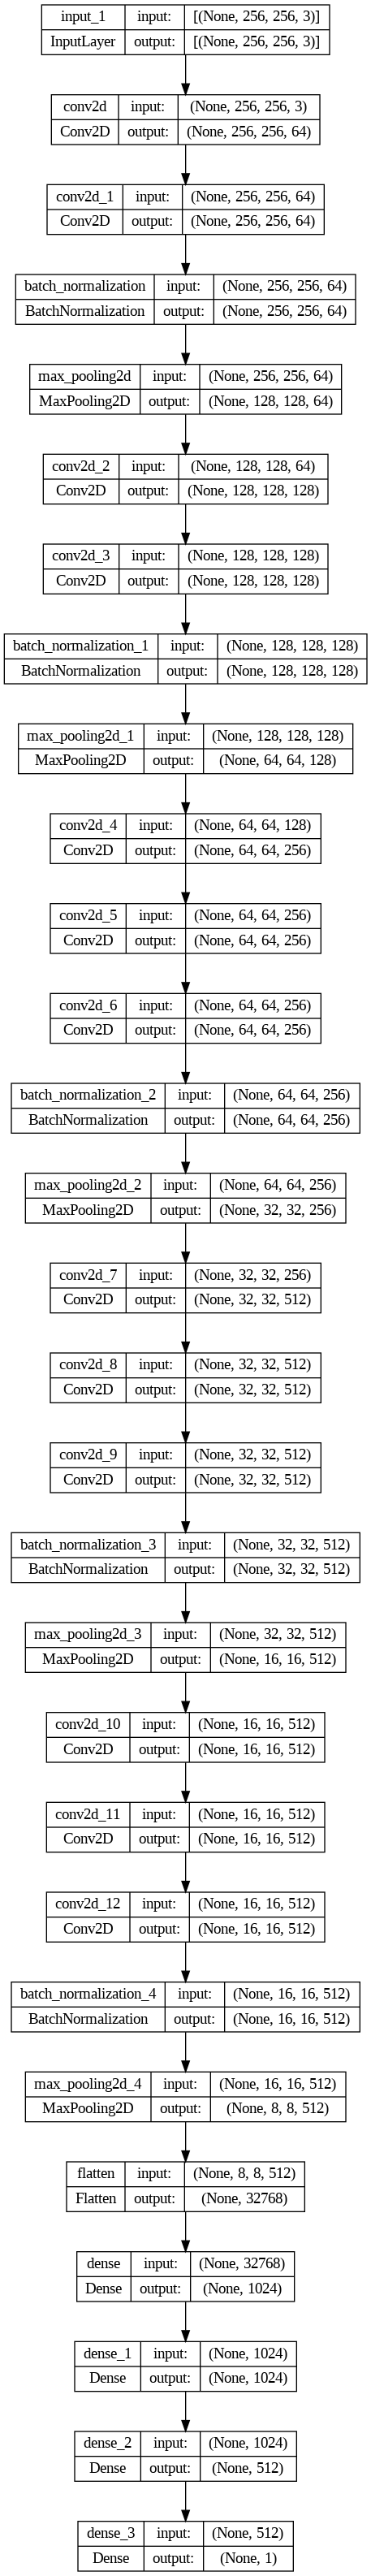

In [37]:
%matplotlib inline

plot_model(model, show_shapes=True, to_file='VGG16.png')

In [ ]:
# 모델 구조 시각화하기
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

손실함수, optimizer, metric을 설정해 줍니다.

손실함수와 metric은 분류 task에 따라 다양하게 바꿀 수 있습니다. optimizer도 Adam 외에 다양한 것을 사용할 수 있습니다. 자유롭게 바꿔보세요.

### 하이퍼 파라미터 설정

In [26]:
loss_function=tf.keras.losses.binary_crossentropy
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

모델 학습을 시켜봅시다.
data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.

일반적으로 (전체 데이터 길이/batch_size)를 steps_per_epoch으로 설정합니다.

### 모델 학습

In [27]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 81s 456ms/step - loss: 24.4184 - binary_accuracy: 0.5000 - val_loss: 0.9408 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 53s 422ms/step - loss: 0.7200 - binary_accuracy: 0.5000 - val_loss: 0.6910 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 53s 422ms/step - loss: 0.6929 - binary_accuracy: 0.5000 - val_loss: 0.6825 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 51s 410ms/step - loss: 0.7006 - binary_accuracy: 0.5000 - val_loss: 0.6880 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 57s 452ms/step - loss: 0.6868 - binary_accuracy: 0.5000 - val_loss: 0.7054 - val_binary_accuracy: 0.5000


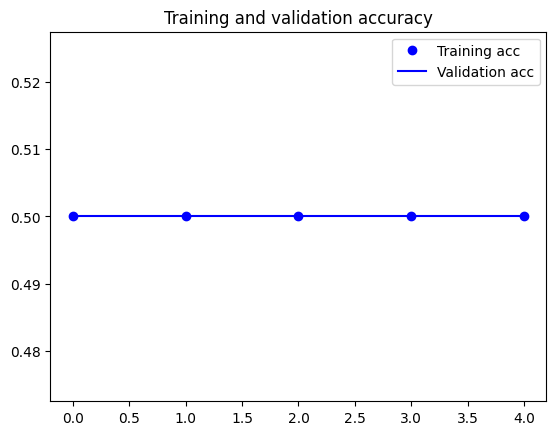

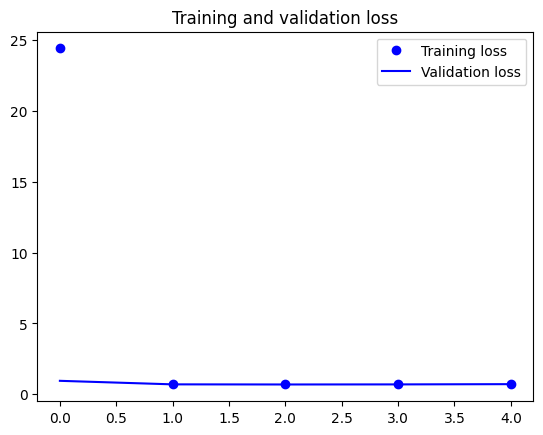

In [28]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 다양한 방법을 사용하여 모델의 성능 올리기

## Parameter 변경하여 모델 성능 올리기

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model # 모델 시각화
%matplotlib inline


_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()



batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256




image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

#    fill_mode='nearest'  # Fill in newly created pixels with the nearest value
'''Fill Mode: Set to 'nearest' to handle pixel values outside the boundaries during transformations.'''

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')


image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')


# 문제 1-2. 모델 구현
input_layer=tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))


conv1=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
conv2=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(conv1)
conv2=tf.keras.layers.BatchNormalization()(conv2)
max1=tf.keras.layers.MaxPool2D((2, 2))(conv2)


conv3=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(max1)
conv4=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(conv3)
conv4=tf.keras.layers.BatchNormalization()(conv4)
max2=tf.keras.layers.MaxPool2D((2, 2))(conv4)


conv5=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(max2)
conv6=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv5)
conv7=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv6)
conv7=tf.keras.layers.BatchNormalization()(conv7)
max3=tf.keras.layers.MaxPool2D((2, 2))(conv7)


conv8=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max3)
conv9=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv8)
conv10=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv9)
conv10=tf.keras.layers.BatchNormalization()(conv10)
max4=tf.keras.layers.MaxPool2D((2, 2))(conv10)


conv11=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max4)
conv12=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv11)
conv13=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv12)
conv13=tf.keras.layers.BatchNormalization()(conv13)
max5=tf.keras.layers.MaxPool2D((2, 2))(conv13)


features=tf.keras.layers.Flatten()(max5)
f4096=tf.keras.layers.Dense(1024, activation='relu')(features)
f4096=tf.keras.layers.Dense(1024, activation='relu')(f4096)
f1000=tf.keras.layers.Dense(512, activation='relu')(f4096)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(f1000)   # softmax -> sigmoid


model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])




loss_function=tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # 0.1 -> 0.001
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=[metric])

history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
125/125 [==============================] - 81s 460ms/step - loss: 1.5169 - binary_accuracy: 0.5190 - val_loss: 0.7505 - val_binary_accuracy: 0.5630
Epoch 2/5
125/125 [==============================] - 56s 446ms/step - loss: 0.7531 - binary_accuracy: 0.5300 - val_loss: 0.6897 - val_binary_accuracy: 0.5280
Epoch 3/5
125/125 [==============================] - 52s 418ms/step - loss: 0.7387 - binary_accuracy: 0.5275 - val_loss: 0.7338 - val_binary_accuracy: 0.5400
Epoch 4/5
125/125 [==============================] - ETA: 0s - loss: 0.7059 - binary_accuracy: 0.5265

KeyboardInterrupt: 

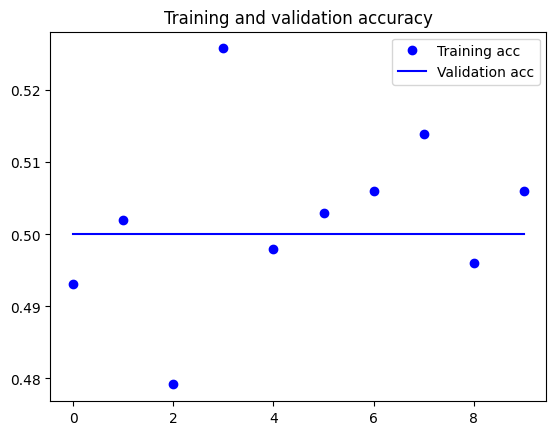

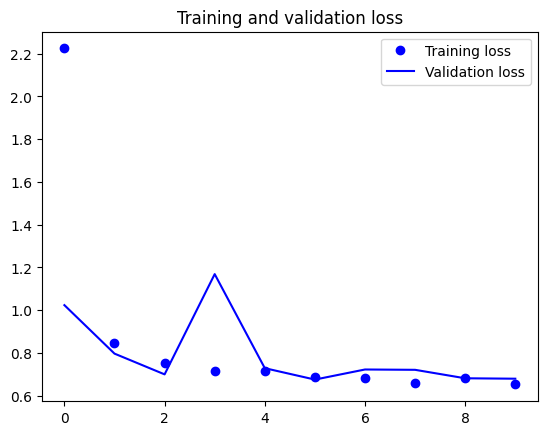

In [40]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## skip connection 사용하여 모델 성능 올리기

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Data augmentation parameters
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Define a residual block function
def residual_block(x, filters, kernel_size=3, stride=1):
    res = x
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if stride != 1 or res.shape[-1] != filters:
        res = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(res)
    x = tf.keras.layers.add([x, res])
    x = tf.keras.layers.Activation('relu')(x)
    return x

input_layer = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = residual_block(x, 64)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

loss_function = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metric = tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function, optimizer=optimizer, metrics=[metric])

history = model.fit(
    train_data_gen,
    steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))) // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=(len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir))) // batch_size
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_78 (Conv2D)          (None, 256, 256, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 256, 256, 64)         256       ['conv2d_78[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_

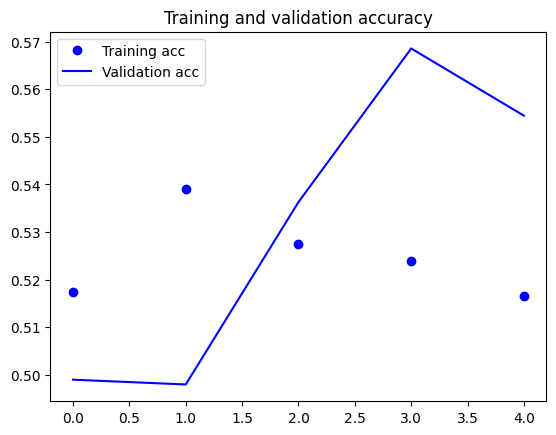

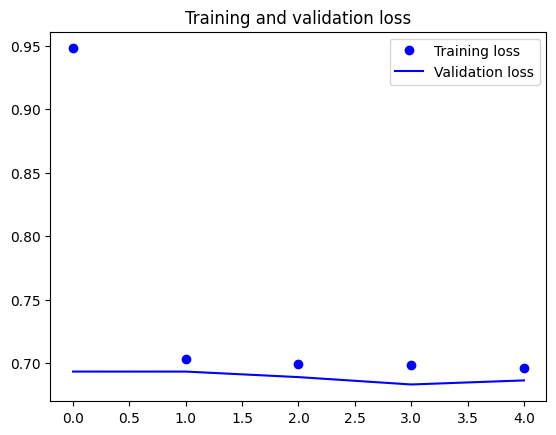

In [11]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()